In [1]:
import pandas as pd

In [2]:
STOCKS = ["AAPL", "GOOGL", "META", "MSFT", "TSLA", "NVDA", "AMZN"]

def read_EIKON(file_path, stocks):
    stock_data = {}
    for stock in stocks:
        full_path = f"{file_path}/Eikon_{stock}.txt"
        df = pd.read_csv(full_path, sep="\t", header=0)
        stock_data[stock] = df
    return stock_data

In [3]:
file_path = "/Users/williamnordansjo/DABEN/DABN01 - Masters' Thesis/Eikon/eikondata"
stock_data_dict = read_EIKON(file_path, STOCKS)

In [4]:
stock_data_dict["AAPL"].head()

,Exchange Date,Close,Volume
0,2025-04-01,"223,19",36 412 740
1,2025-03-31,"222,13",65 299 321
2,2025-03-28,"217,90",39 818 617
3,2025-03-27,"223,85",37 094 774
4,2025-03-26,"221,53",34 532 656


In [5]:
def read_sentiment_outputs(folder_path, stocks):
    sentiment_dfs = {}
    
    for stock in stocks:
        file_path = f"{folder_path}/{stock}_sentiment_output.csv"
        df = pd.read_csv(file_path)
        sentiment_dfs[stock] = df  
    
    return sentiment_dfs

In [6]:
folder_path_sent = "/Users/williamnordansjo/DABEN/DABN01 - Masters' Thesis/Sentiment Data"
sentiment_dfs = read_sentiment_outputs(folder_path_sent, STOCKS)

In [7]:
sentiment_dfs["AAPL"].head()

,index,Date,sentiment_vader,sentiment_finbert,sentiment_roberta
0,36,2023-09-25 00:00:00 UTC,5.0,5.0,2.5
1,92,2023-06-02 00:00:00 UTC,5.0,5.0,2.5
2,258,2023-01-27 00:00:00 UTC,5.0,0.0,5.0
3,374,2022-09-29 00:00:00 UTC,5.0,2.5,2.5
4,1108,2020-10-27 00:00:00 UTC,5.0,5.0,2.5


In [8]:
stock_data_dict["AAPL"].head()

,Exchange Date,Close,Volume
0,2025-04-01,"223,19",36 412 740
1,2025-03-31,"222,13",65 299 321
2,2025-03-28,"217,90",39 818 617
3,2025-03-27,"223,85",37 094 774
4,2025-03-26,"221,53",34 532 656


In [9]:
import numpy as np
import pandas as pd

def fill_sentiment_decay(stock_symbol, price_df, sentiment_df, B=1.5):
    # --- Format dates ---
    price_df = price_df.copy()
    price_df['date'] = pd.to_datetime(price_df['Exchange Date']).dt.date
    price_df = price_df[['date', 'Close', 'Volume']].rename(columns={'Close': 'close', 'Volume': 'volume'})

    # --- Format sentiment ---
    s_df = sentiment_df.copy()
    s_df['date'] = pd.to_datetime(s_df['Date']).dt.date

    # --- Step 1: Average sentiment per day per model ---
    daily_avg = s_df.groupby('date')[['sentiment_vader', 'sentiment_finbert', 'sentiment_roberta']].mean()
    daily_count = s_df.groupby('date').size().rename('num_articles')

    # --- Step 2: Merge with price data ---
    df = price_df.copy()
    df['stock_symbol'] = stock_symbol
    df = df.merge(daily_avg, how='left', on='date')
    df = df.merge(daily_count, how='left', on='date')
    df['num_articles'] = df['num_articles'].fillna(0).astype(int)

    # --- Step 3: Create boolean update column ---
    df['sentiment_updated'] = ~df[['sentiment_vader', 'sentiment_finbert', 'sentiment_roberta']].isna().all(axis=1)

    # --- Step 4: Sort by date ascending! ---
    df = df.sort_values('date').reset_index(drop=True)

    # --- Step 5: Fill and decay missing sentiments ---
    for col in ['sentiment_vader', 'sentiment_finbert', 'sentiment_roberta']:
        values = []
        last_val = 2.5  # Start neutral
        steps_since_update = 0

        for i, row in df.iterrows():
            val = row[col]

            if not np.isnan(val):
                # Real update
                values.append(val)
                last_val = val
                steps_since_update = 0
            else:
                steps_since_update += 1
                decayed = 2.5 + (last_val - 2.5) / (steps_since_update ** B)
                values.append(decayed)

        df[col] = values  # Overwrite with filled/decayed values

    return df


In [10]:
stocks = ["AAPL", "GOOGL", "META", "MSFT", "TSLA", "NVDA", "AMZN"]


filled_sentiment_dfs = {}

for stock in stocks:
    price_df = stock_data_dict[stock]
    sentiment_df = sentiment_dfs[stock]
    filled_df = fill_sentiment_decay(stock, price_df, sentiment_df)
    filled_sentiment_dfs[stock] = filled_df

In [11]:
filled_sentiment_dfs["AAPL"].head()

,date,close,volume,stock_symbol,sentiment_vader,sentiment_finbert,sentiment_roberta,num_articles,sentiment_updated
0,2006-01-03,"2,67",807 412 951,AAPL,2.5,2.5,2.5,0,False
1,2006-01-04,"2,68",620 903 057,AAPL,2.5,2.5,2.5,0,False
2,2006-01-05,"2,66",449 584 774,AAPL,2.5,2.5,2.5,0,False
3,2006-01-06,"2,72",704 558 041,AAPL,2.5,2.5,2.5,0,False
4,2006-01-09,"2,72",675 445 571,AAPL,2.5,2.5,2.5,0,False


In [12]:
from datetime import date

def cut_all_stocks_at_fixed_date(sentiment_dfs, cutoff_date=date(2023, 12, 26)):
    cut_sentiment_dfs = {}

    for stock, df in sentiment_dfs.items():
        cut_df = df[df['date'] <= cutoff_date].copy()
        cut_sentiment_dfs[stock] = cut_df

        print(f"{stock}: kept {len(cut_df)} rows (up to {cutoff_date})")
    
    return cut_sentiment_dfs


In [13]:
trimmed_sentiment_dfs = cut_all_stocks_at_fixed_date(filled_sentiment_dfs)

AAPL: kept 4526 rows (up to 2023-12-26)
GOOGL: kept 4696 rows (up to 2023-12-26)
META: kept 2920 rows (up to 2023-12-26)
MSFT: kept 4698 rows (up to 2023-12-26)
TSLA: kept 3397 rows (up to 2023-12-26)
NVDA: kept 4698 rows (up to 2023-12-26)
AMZN: kept 4698 rows (up to 2023-12-26)


In [14]:
trimmed_sentiment_dfs["AAPL"].tail(50)

,date,close,volume,stock_symbol,sentiment_vader,sentiment_finbert,sentiment_roberta,num_articles,sentiment_updated
4476,2023-10-16,"178,72",52 516 984,AAPL,2.456140,2.412281,2.587719,57,True
4477,2023-10-17,"177,15",57 549 350,AAPL,5.000000,4.852941,2.573529,34,True
4478,2023-10-18,"175,84",54 764 375,AAPL,5.000000,3.571429,3.571429,7,True
4479,2023-10-19,"175,46",59 302 863,AAPL,5.000000,2.713415,2.957317,82,True
4480,2023-10-20,"172,88",64 244 028,AAPL,5.000000,4.004425,4.225664,113,True
4481,2023-10-23,"173,00",55 980 109,AAPL,5.000000,0.632530,2.740964,83,True
4482,2023-10-24,"173,44",43 816 644,AAPL,4.444444,3.611111,2.222222,9,True
4483,2023-10-25,"171,10",57 156 962,AAPL,5.000000,4.523810,2.559524,42,True
4484,2023-10-26,"166,89",70 625 258,AAPL,4.333333,4.416667,3.416667,30,True
4485,2023-10-27,"168,22",58 499 129,AAPL,4.375000,1.875000,4.062500,8,True


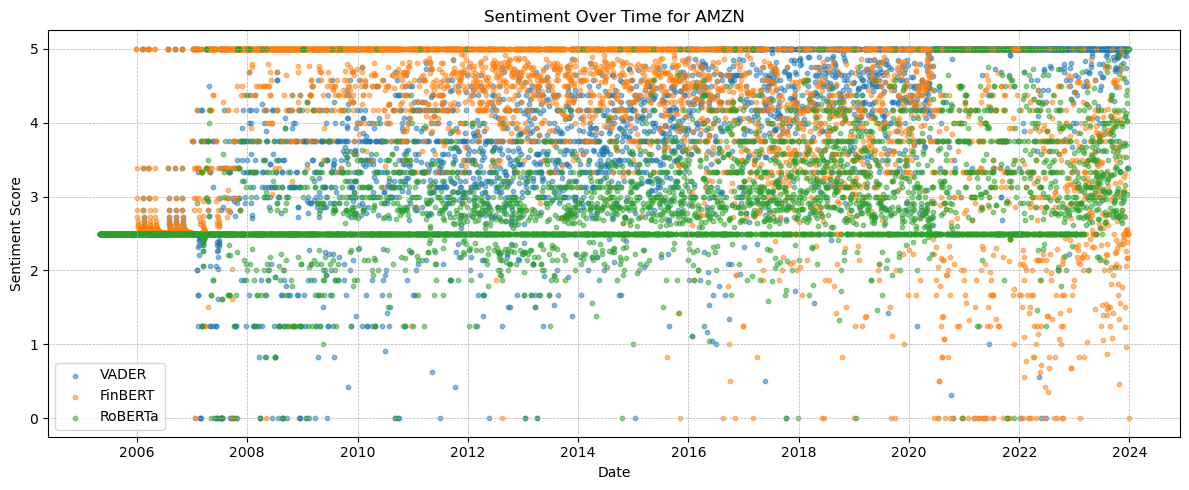

In [15]:
import matplotlib.pyplot as plt

df = trimmed_sentiment_dfs["AMZN"]
df_plot = df.set_index('date')

plt.figure(figsize=(12, 5))
plt.scatter(df_plot.index, df_plot['sentiment_vader'], label='VADER', alpha=0.5, s=10)
plt.scatter(df_plot.index, df_plot['sentiment_finbert'], label='FinBERT', alpha=0.5, s=10)
plt.scatter(df_plot.index, df_plot['sentiment_roberta'], label='RoBERTa', alpha=0.5, s=10)

plt.legend()
plt.title(f"Sentiment Over Time for {df['stock_symbol'].iloc[0]}")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [16]:
#for stock, df in trimmed_sentiment_dfs.items():
#    df.to_csv(f"{stock}_complete_fixed.csv", index=False)
#    print(f"✅ Saved {stock}_complete_fixed.csv with {len(df)} rows")

In [38]:
def summarize_sentiment_data(sentiment_dfs):
    summaries = {}

    for stock, df in sentiment_dfs.items():
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])

        numeric_cols = ['close', 'volume', 'sentiment_vader', 'sentiment_finbert', 'sentiment_roberta', 'num_articles']

        # Remove spaces and commas, then convert to numeric
        # Fix 'close' with comma as decimal
        df['close'] = df['close'].astype(str).str.replace(',', '.').str.replace(' ', '')
        df['close'] = pd.to_numeric(df['close'], errors='coerce')

        # Fix 'volume' with thousands separator
        df['volume'] = df['volume'].astype(str).str.replace(r"[ ,]", "", regex=True)
        df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

        # Convert the sentiment columns safely
        for col in ['sentiment_vader', 'sentiment_finbert', 'sentiment_roberta']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        summary = {
            "date_min": df['date'].min(),
            "date_max": df['date'].max(),
        }

        for col in numeric_cols:
            summary[f"{col}_mean"] = df[col].mean()
            summary[f"{col}_std"] = df[col].std()
            summary[f"{col}_min"] = df[col].min()
            summary[f"{col}_max"] = df[col].max()

        summary["total_articles"] = df['num_articles'].sum()
        summary["sentiment_updated_true"] = df['sentiment_updated'].mean()
        summary["sentiment_updated_false"] = 1 - summary["sentiment_updated_true"]

        summaries[stock] = summary

    return pd.DataFrame(summaries).T


In [39]:
summary_df = summarize_sentiment_data(trimmed_sentiment_dfs)
summary_df.head()

,date_min,date_max,close_mean,close_std,close_min,close_max,volume_mean,volume_std,volume_min,volume_max,...,sentiment_roberta_std,sentiment_roberta_min,sentiment_roberta_max,num_articles_mean,num_articles_std,num_articles_min,num_articles_max,total_articles,sentiment_updated_true,sentiment_updated_false
AAPL,2006-01-03 00:00:00,2023-12-26 00:00:00,47.47494,53.971194,1.81,198.11,385858338.535572,387643101.746979,24048344,3373059549,...,0.527959,0.0,5.0,21.508617,27.611708,0,816,97348,0.949624,0.050376
GOOGL,2005-05-02 00:00:00,2023-12-26 00:00:00,43.265111,38.605305,5.56,149.84,64431068.912692,62716598.958765,9312760,823657780,...,0.635542,0.0,5.0,12.074744,26.552357,0,779,56703,0.920784,0.079216
META,2012-05-18 00:00:00,2023-12-26 00:00:00,157.489103,90.748354,17.73,382.18,30645940.42089,26447841.865015,5467488,580587742,...,0.826804,0.0,5.0,9.028767,18.722433,0,369,26364,0.921233,0.078767
MSFT,2005-04-28 00:00:00,2023-12-26 00:00:00,92.84804,95.96605,15.15,382.7,45123561.635164,28405226.354652,7425603,591078581,...,0.627429,0.0,5.0,9.064283,12.968006,0,372,42584,0.889953,0.110047
TSLA,2010-06-29 00:00:00,2023-12-26 00:00:00,70.311849,101.378171,1.05,409.97,96876509.388873,80144525.729943,1779212,914082284,...,0.683937,0.0,5.0,10.617898,26.202438,0,598,36069,0.925228,0.074772


In [41]:
print(summary_df.columns.tolist())


['date_min', 'date_max', 'close_mean', 'close_std', 'close_min', 'close_max', 'volume_mean', 'volume_std', 'volume_min', 'volume_max', 'sentiment_vader_mean', 'sentiment_vader_std', 'sentiment_vader_min', 'sentiment_vader_max', 'sentiment_finbert_mean', 'sentiment_finbert_std', 'sentiment_finbert_min', 'sentiment_finbert_max', 'sentiment_roberta_mean', 'sentiment_roberta_std', 'sentiment_roberta_min', 'sentiment_roberta_max', 'num_articles_mean', 'num_articles_std', 'num_articles_min', 'num_articles_max', 'total_articles', 'sentiment_updated_true', 'sentiment_updated_false']


In [43]:
covariates_df = summary_df[['date_min', 'date_max', 'close_mean', 'close_std', 'close_min', 'close_max', 'volume_mean', 'volume_std', 'volume_min', 'volume_max']
                          ]
sentiments_df = summary_df[['sentiment_vader_mean', 'sentiment_vader_std', 'sentiment_vader_min', 'sentiment_vader_max', 'sentiment_finbert_mean', 'sentiment_finbert_std', 'sentiment_finbert_min', 'sentiment_finbert_max', 'sentiment_roberta_mean', 'sentiment_roberta_std', 'sentiment_roberta_min', 'sentiment_roberta_max']
                          ]
articles_df = summary_df[['num_articles_mean', 'num_articles_std', 'num_articles_min', 'num_articles_max','total_articles', 'sentiment_updated_true', 'sentiment_updated_false']
                        ]

In [35]:
covariates_df

,date_min,date_max,close_mean,close_std,close_min,close_max,volume_mean,volume_std,volume_min,volume_max
AAPL,2006-01-03 00:00:00,2023-12-26 00:00:00,47.47494,53.971194,1.81,198.11,385858338.535572,387643101.746979,24048344,3373059549
GOOGL,2005-05-02 00:00:00,2023-12-26 00:00:00,43.265111,38.605305,5.56,149.84,64431068.912692,62716598.958765,9312760,823657780
META,2012-05-18 00:00:00,2023-12-26 00:00:00,157.489103,90.748354,17.73,382.18,30645940.42089,26447841.865015,5467488,580587742
MSFT,2005-04-28 00:00:00,2023-12-26 00:00:00,92.84804,95.96605,15.15,382.7,45123561.635164,28405226.354652,7425603,591078581
TSLA,2010-06-29 00:00:00,2023-12-26 00:00:00,70.311849,101.378171,1.05,409.97,96876509.388873,80144525.729943,1779212,914082284
NVDA,2005-04-28 00:00:00,2023-12-26 00:00:00,5.545528,9.823622,0.15,50.41,550569387.310345,324669522.567322,45645120,3692927840
AMZN,2005-04-28 00:00:00,2023-12-26 00:00:00,48.165815,54.081683,1.3,186.57,107450731.335036,90032640.443125,17626740,2088091780


In [36]:
sentiments_df

,sentiment_vader_mean,sentiment_vader_std,sentiment_vader_min,sentiment_vader_max,sentiment_finbert_mean,sentiment_finbert_std,sentiment_finbert_min,sentiment_finbert_max,sentiment_roberta_mean,sentiment_roberta_std,sentiment_roberta_min,sentiment_roberta_max
AAPL,3.560624,0.934795,0.0,5.0,4.166514,0.833455,0.0,5.0,2.836018,0.527959,0.0,5.0
GOOGL,3.477018,1.033827,0.0,5.0,4.214435,1.021444,0.0,5.0,2.792069,0.635542,0.0,5.0
META,3.704584,1.138879,0.0,5.0,3.971792,1.230332,0.0,5.0,2.87695,0.826804,0.0,5.0
MSFT,3.726697,1.079217,0.0,5.0,4.074035,1.09517,0.0,5.0,2.769052,0.627429,0.0,5.0
TSLA,3.65961,1.138022,0.0,5.0,4.051128,1.104836,0.0,5.0,2.794556,0.683937,0.0,5.0
NVDA,3.41628,1.273133,0.0,5.0,3.376164,1.290495,0.0,5.0,2.723424,0.679466,0.0,5.0
AMZN,3.799216,1.094265,0.0,5.0,3.965102,1.126653,0.0,5.0,2.868546,0.693208,0.0,5.0


In [44]:
articles_df

,num_articles_mean,num_articles_std,num_articles_min,num_articles_max,total_articles,sentiment_updated_true,sentiment_updated_false
AAPL,21.508617,27.611708,0,816,97348,0.949624,0.050376
GOOGL,12.074744,26.552357,0,779,56703,0.920784,0.079216
META,9.028767,18.722433,0,369,26364,0.921233,0.078767
MSFT,9.064283,12.968006,0,372,42584,0.889953,0.110047
TSLA,10.617898,26.202438,0,598,36069,0.925228,0.074772
NVDA,3.737761,17.091178,0,430,17560,0.46871,0.53129
AMZN,9.535547,21.683208,0,596,44798,0.85845,0.14155
